## Подготовка и удаление не нужных столбцов в датасете

In [ ]:
import pandas as pd
from datetime import datetime


data_columns = [
    'account_id', 'name', 'point', 'call_count', 'total_call_time', 'total_exclusive_time', 'min_call_time', 'max_call_time', 'sum_of_squares', 'instances', 'language', 'app_name', 'app_id', 'scope', 'host', 'display_host', 'pid', 'agent_version', 'labels'
]

df = pd.read_csv('/content/filtered_data.csv', sep='\t', names=data_columns)

delete_columns = ['agent_version', 'labels', 'account_id', 'name', 'language', 'app_name', 'app_id', 'host', 'display_host']
df.drop(delete_columns, axis=1, inplace=True)


                  point  call_count  total_call_time  total_exclusive_time  \
0   2024-04-21 09:01:00      1351.5                0                   0.0   
1   2024-04-21 09:02:00      1337.5                0                   0.0   
2   2024-04-21 09:03:00      1362.0                0                   0.0   
3   2024-04-21 09:04:00      1365.5                0                   0.0   
4   2024-04-21 09:05:00      1306.0                0                   0.0   
5   2024-04-21 09:06:00      1238.5                0                   0.0   
6   2024-04-21 09:07:00      1186.0                0                   0.0   
7   2024-04-21 09:08:00      1208.0                0                   0.0   
8   2024-04-21 09:09:00      1206.5                0                   0.0   
9   2024-04-21 09:10:00      1199.0                0                   0.0   
10  2024-04-21 09:11:00      1231.0                0                   0.0   
11  2024-04-21 09:12:00      1261.5                0            

## Читаем датасет и получаем списки с метриками которые нас интересуют


In [ ]:
from typing import Callable
import pandas as pd
from datetime import datetime
import numpy as np


def load_data():
    data_columns = [
        'account_id', 'name', 'point', 'call_count', 'total_call_time', 'total_exclusive_time', 'min_call_time', 'max_call_time', 'sum_of_squares', 'instances', 'language', 'app_name', 'app_id', 'scope', 'host', 'display_host', 'pid', 'agent_version', 'labels'
    ]

    df = pd.read_csv('/content/filtered_data.csv', sep=',', names=data_columns)
    df = df.drop(index=0)
    df = df.fillna('')
    df = df.sort_values(by='point')

    df['call_count'] = df['call_count'].astype(float)
    df['total_call_time'] = df['total_call_time'].astype(float)
    df['total_exclusive_time'] = df['total_exclusive_time'].astype(float)

    delete_columns = ['agent_version', 'labels', 'account_id',  'app_id', 'host', 'display_host']
    df.drop(delete_columns, axis=1, inplace=True)


    return df
def base_proect(df: pd.DataFrame, proect_fun: Callable):
    list_of_data = df.to_dict('records')

    res_list = []
    for data in list_of_data:
        time = data['point']

        # Использование pd.to_datetime для обработки ошибок
        time = pd.to_datetime(time, format='%Y-%m-%d %H:%M:%S', errors='coerce')

        # Пропуск строк с некорректной датой
        if pd.isna(time):
            continue

        timestamp = int(time.timestamp())
        value = proect_fun(data)
        if value is None:
            continue

        res_list.append(
            {timestamp: value}
        )

    return res_list


def web_response(data: dict):
    check = data['language'] == 'java' and data['app_name'] == '[GMonit] Collector' and data['scope'] == '' and data['name'] == 'HttpDispatcher'
    if not check:
        return None

    total_call_time = data['total_call_time']
    call_count = data['call_count']
    if total_call_time and call_count:
        return total_call_time / call_count
    else:
        return 0


def throughput(data: dict):
    check = data['language'] == 'java' and data['app_name'] == '[GMonit] Collector' and data['scope'] == '' and data['name'] == 'HttpDispatcher'
    if not check:
        return None

    call_count = data['call_count']
    if call_count:
        return call_count
    else:
        return 0


def apdex(data: dict):
    check = data['language'] == 'java' and data['app_name'] == '[GMonit] Collector' and data['scope'] == '' and data['name'] == 'Apdex'
    if not check:
        return None

    s = data['call_count']
    t = data['total_call_time']
    f = data['total_exclusive_time']

    if s and t and f:
        return (s + t/2) / (s + t + f)
    else:
        return 0



def main():
    df = load_data()
    web_response_list = base_proect(df, web_response)
    throughput_list = base_proect(df, throughput)
    apdex_list = base_proect(df, apdex)



In [ ]:
df = load_data()
#list_graphs = [web_response_list = base_proect(df, web_response), throughput_list = base_proect(df, throughput), ]
web_response_list = base_proect(df, web_response)
throughput_list = base_proect(df, throughput)
apdex_list = base_proect(df, apdex)

In [ ]:
df.head(10)

,name,point,call_count,total_call_time,total_exclusive_time,min_call_time,max_call_time,sum_of_squares,instances,language,app_name,scope,pid
1,Apdex,2024-04-15 23:32:00,3896.0,1.500000,0.500000,0.5,0.5,0.0,1.0,java,[GMonit] Collector,,1
60645,HttpDispatcher,2024-04-15 23:32:00,3898.0,30.099163,30.099163,0.000091,0.785708,2.049792,1.0,java,[GMonit] Collector,,1
60646,HttpDispatcher,2024-04-15 23:33:00,3917.5,32.763374,32.763374,0.000103,3.822411,8.938635,1.0,java,[GMonit] Collector,,1
2,Apdex,2024-04-15 23:33:00,3916.5,0.000000,1.000000,0.5,0.5,0.0,1.0,java,[GMonit] Collector,,1
3,Apdex,2024-04-15 23:34:00,3991.5,0.500000,1.000000,0.5,0.5,0.0,1.0,java,[GMonit] Collector,,1
60647,HttpDispatcher,2024-04-15 23:34:00,3993.0,34.776276,34.776276,0.00011,3.822411,16.068309,1.0,java,[GMonit] Collector,,1
4,Apdex,2024-04-15 23:35:00,3990.5,0.500000,0.500000,0.5,0.5,0.0,1.0,java,[GMonit] Collector,,1
60648,HttpDispatcher,2024-04-15 23:35:00,3991.5,33.072502,33.072502,0.00011,3.659296,8.886156,1.0,java,[GMonit] Collector,,1
60649,HttpDispatcher,2024-04-15 23:36:00,3915.5,42.575750,42.575750,0.000107,15.111876,135.348995,1.0,java,[GMonit] Collector,,1
5,Apdex,2024-04-15 23:36:00,3912.5,2.000000,1.000000,0.5,0.5,0.0,1.0,java,[GMonit] Collector,,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 86566 entries, 1 to 85938
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   name                  86566 non-null  object 
 1   point                 86566 non-null  object 
 2   call_count            86566 non-null  float64
 3   total_call_time       86566 non-null  float64
 4   total_exclusive_time  86566 non-null  float64
 5   min_call_time         86566 non-null  object 
 6   max_call_time         86566 non-null  object 
 7   sum_of_squares        86566 non-null  object 
 8   instances             86566 non-null  object 
 9   language              86566 non-null  object 
 10  app_name              86566 non-null  object 
 11  scope                 86566 non-null  object 
 12  pid                   86566 non-null  object 
dtypes: float64(3), object(10)
memory usage: 11.3+ MB


## Пробуем детектить аномалии

In [ ]:
!pip install plotly -quiet


### Тест ADF (расширенный тест Дики – Фуллера) – проверка Статистической значимости

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Загрузка данных
# Предположим, что у вас есть DataFrame 'df', и временной ряд находится в столбце 'point'
# Если у вас уже есть DataFrame 'df', вам не нужно повторно загружать данные
# Замените 'data.csv' на путь к вашему файлу данных


# Выберите временной ряд из столбца 'point'
df['point'] = pd.to_datetime(df['point'])

# Использование меток времени для временного ряда
time_series = df['point'].values

# Проведение теста ADF
result = adfuller(time_series)

# Вывод результатов
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: 35.73901061761052
p-value: 1.0
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


### ARIMA

In [ ]:
df

,value
2024-04-15 23:32:00,3898.0
2024-04-15 23:33:00,3917.5
2024-04-15 23:34:00,3993.0
2024-04-15 23:35:00,3991.5
2024-04-15 23:36:00,3915.5
...,...
2024-05-16 00:54:00,2560.0
2024-05-16 00:55:00,2491.0
2024-05-16 00:56:00,2429.0
2024-05-16 00:57:00,2373.5


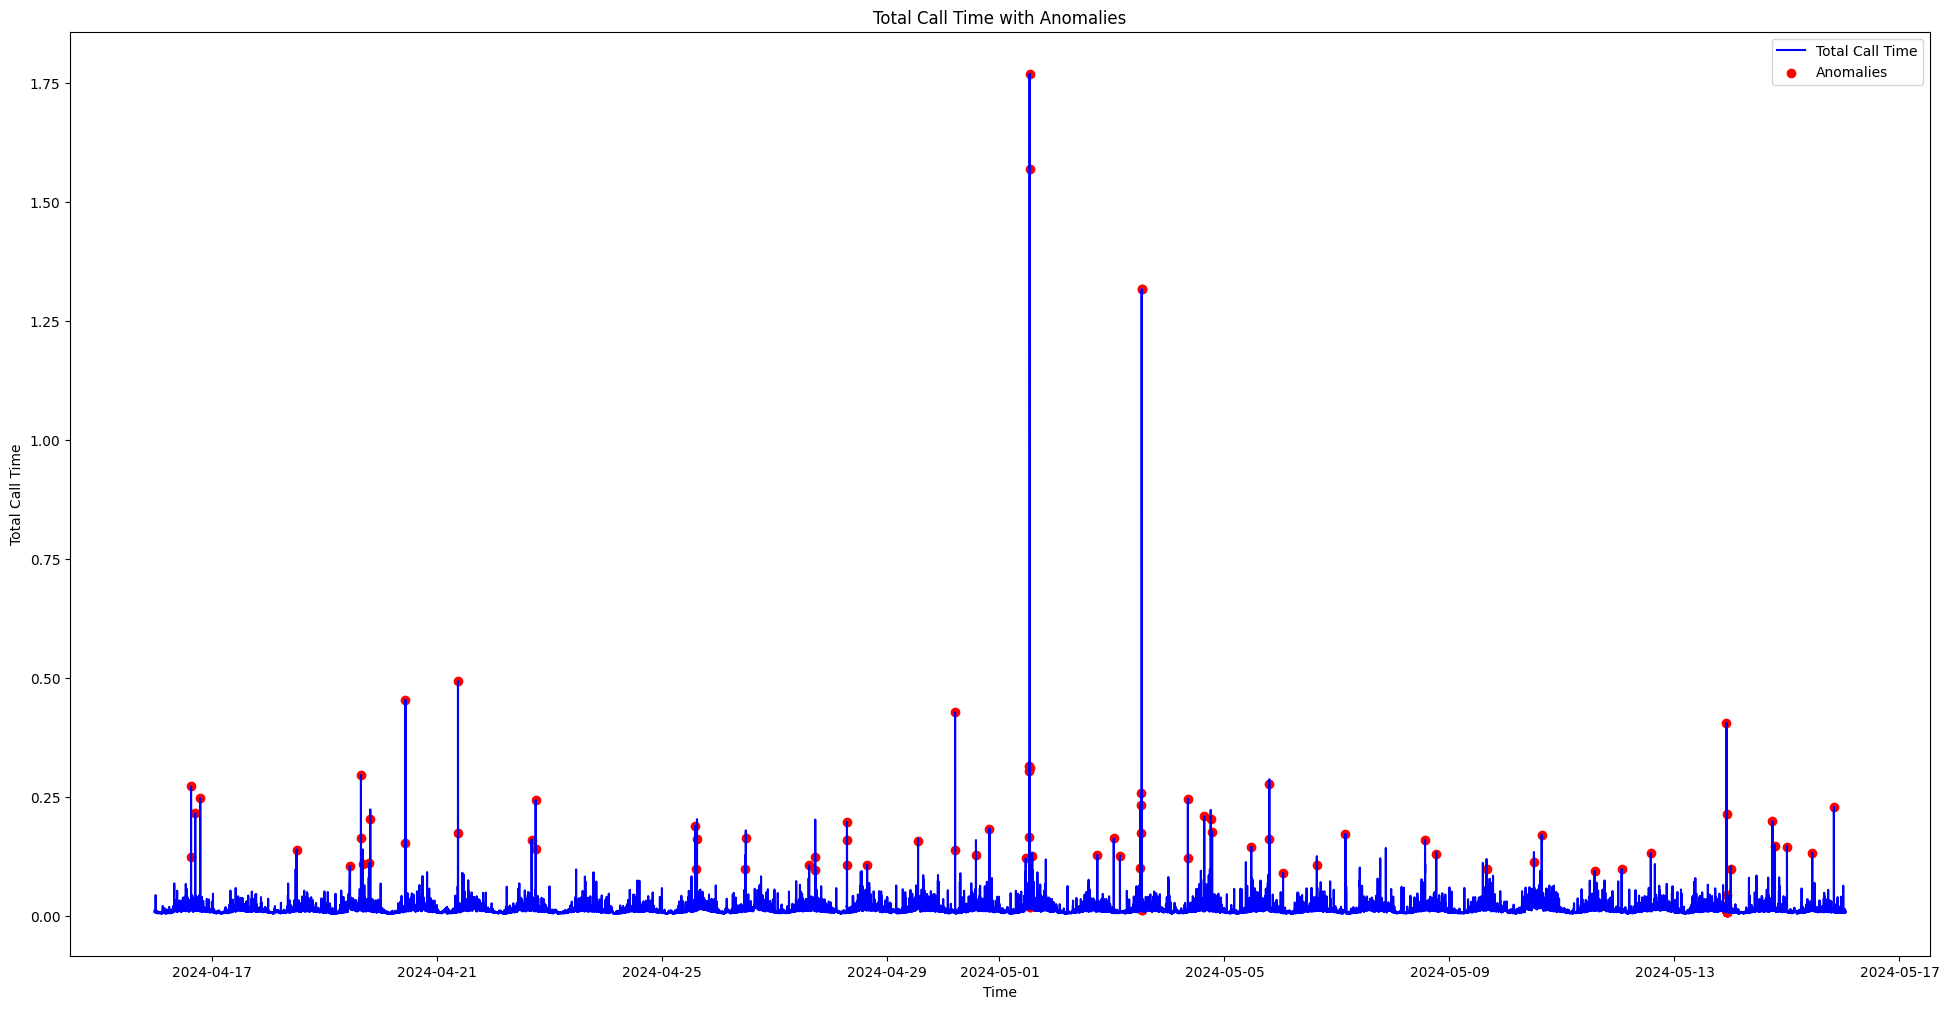

[[1713223920, 1713223980, 1713224040, 1713224100, 1713224160, 1713224220, 1713224280, 1713224340, 1713224400, 1713224460, 1713224520, 1713224580, 1713224640, 1713224700, 1713224760, 1713224820, 1713224880, 1713224940, 1713225000, 1713225060, 1713225120, 1713225180, 1713225240, 1713225300, 1713225360, 1713225420, 1713225480, 1713225540, 1713225600, 1713225660, 1713225720, 1713225780, 1713225840, 1713225900, 1713225960, 1713226020, 1713226080, 1713226140, 1713226200, 1713226260, 1713226320, 1713226380, 1713226440, 1713226500, 1713226560, 1713226620, 1713226680, 1713226740, 1713226800, 1713226860, 1713226920, 1713226980, 1713227040, 1713227100, 1713227160, 1713227220, 1713227280, 1713227340, 1713227400, 1713227460, 1713227520, 1713227580, 1713227640, 1713227700, 1713227760, 1713227820, 1713227880, 1713227940, 1713228000, 1713228060, 1713228120, 1713228180, 1713228240, 1713228300, 1713228360, 1713228420, 1713228480, 1713228540, 1713228600, 1713228660, 1713228720, 1713228780, 1713228840, 17

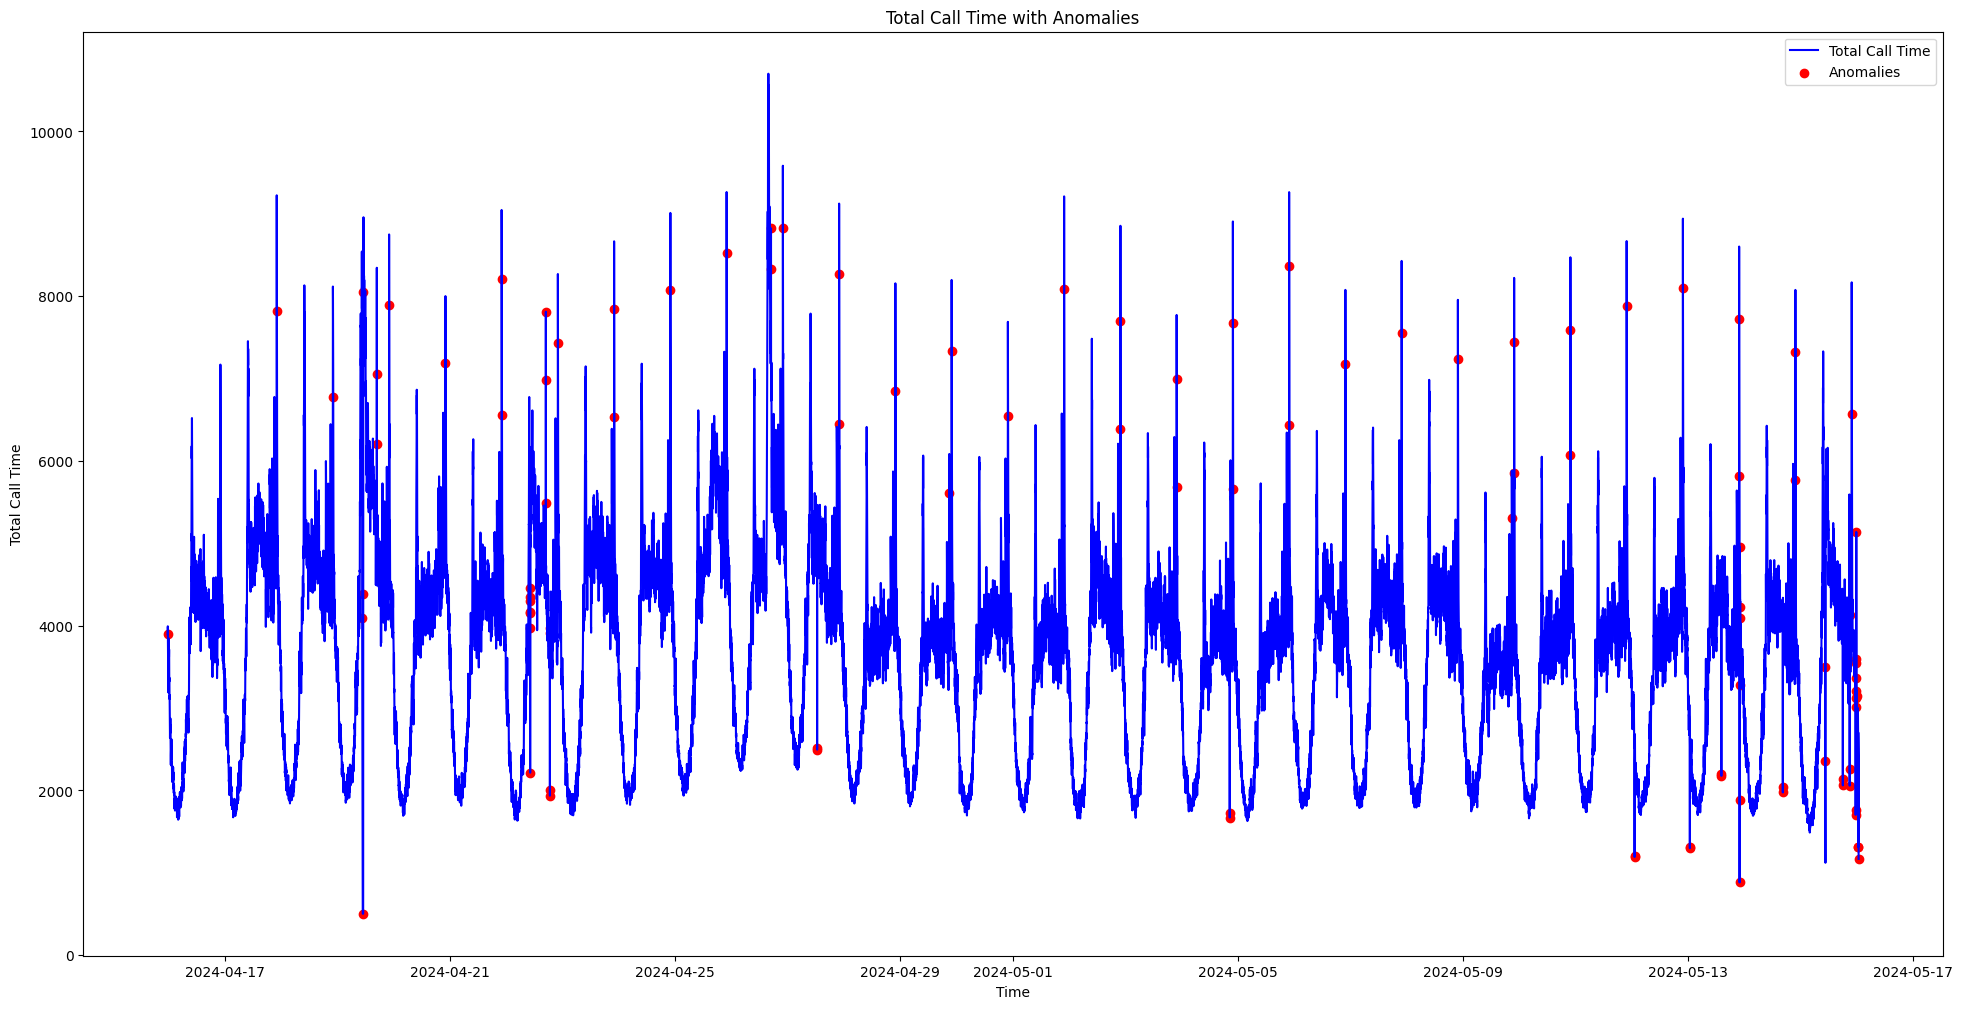

[[1713223920, 1713223980, 1713224040, 1713224100, 1713224160, 1713224220, 1713224280, 1713224340, 1713224400, 1713224460, 1713224520, 1713224580, 1713224640, 1713224700, 1713224760, 1713224820, 1713224880, 1713224940, 1713225000, 1713225060, 1713225120, 1713225180, 1713225240, 1713225300, 1713225360, 1713225420, 1713225480, 1713225540, 1713225600, 1713225660, 1713225720, 1713225780, 1713225840, 1713225900, 1713225960, 1713226020, 1713226080, 1713226140, 1713226200, 1713226260, 1713226320, 1713226380, 1713226440, 1713226500, 1713226560, 1713226620, 1713226680, 1713226740, 1713226800, 1713226860, 1713226920, 1713226980, 1713227040, 1713227100, 1713227160, 1713227220, 1713227280, 1713227340, 1713227400, 1713227460, 1713227520, 1713227580, 1713227640, 1713227700, 1713227760, 1713227820, 1713227880, 1713227940, 1713228000, 1713228060, 1713228120, 1713228180, 1713228240, 1713228300, 1713228360, 1713228420, 1713228480, 1713228540, 1713228600, 1713228660, 1713228720, 1713228780, 1713228840, 17

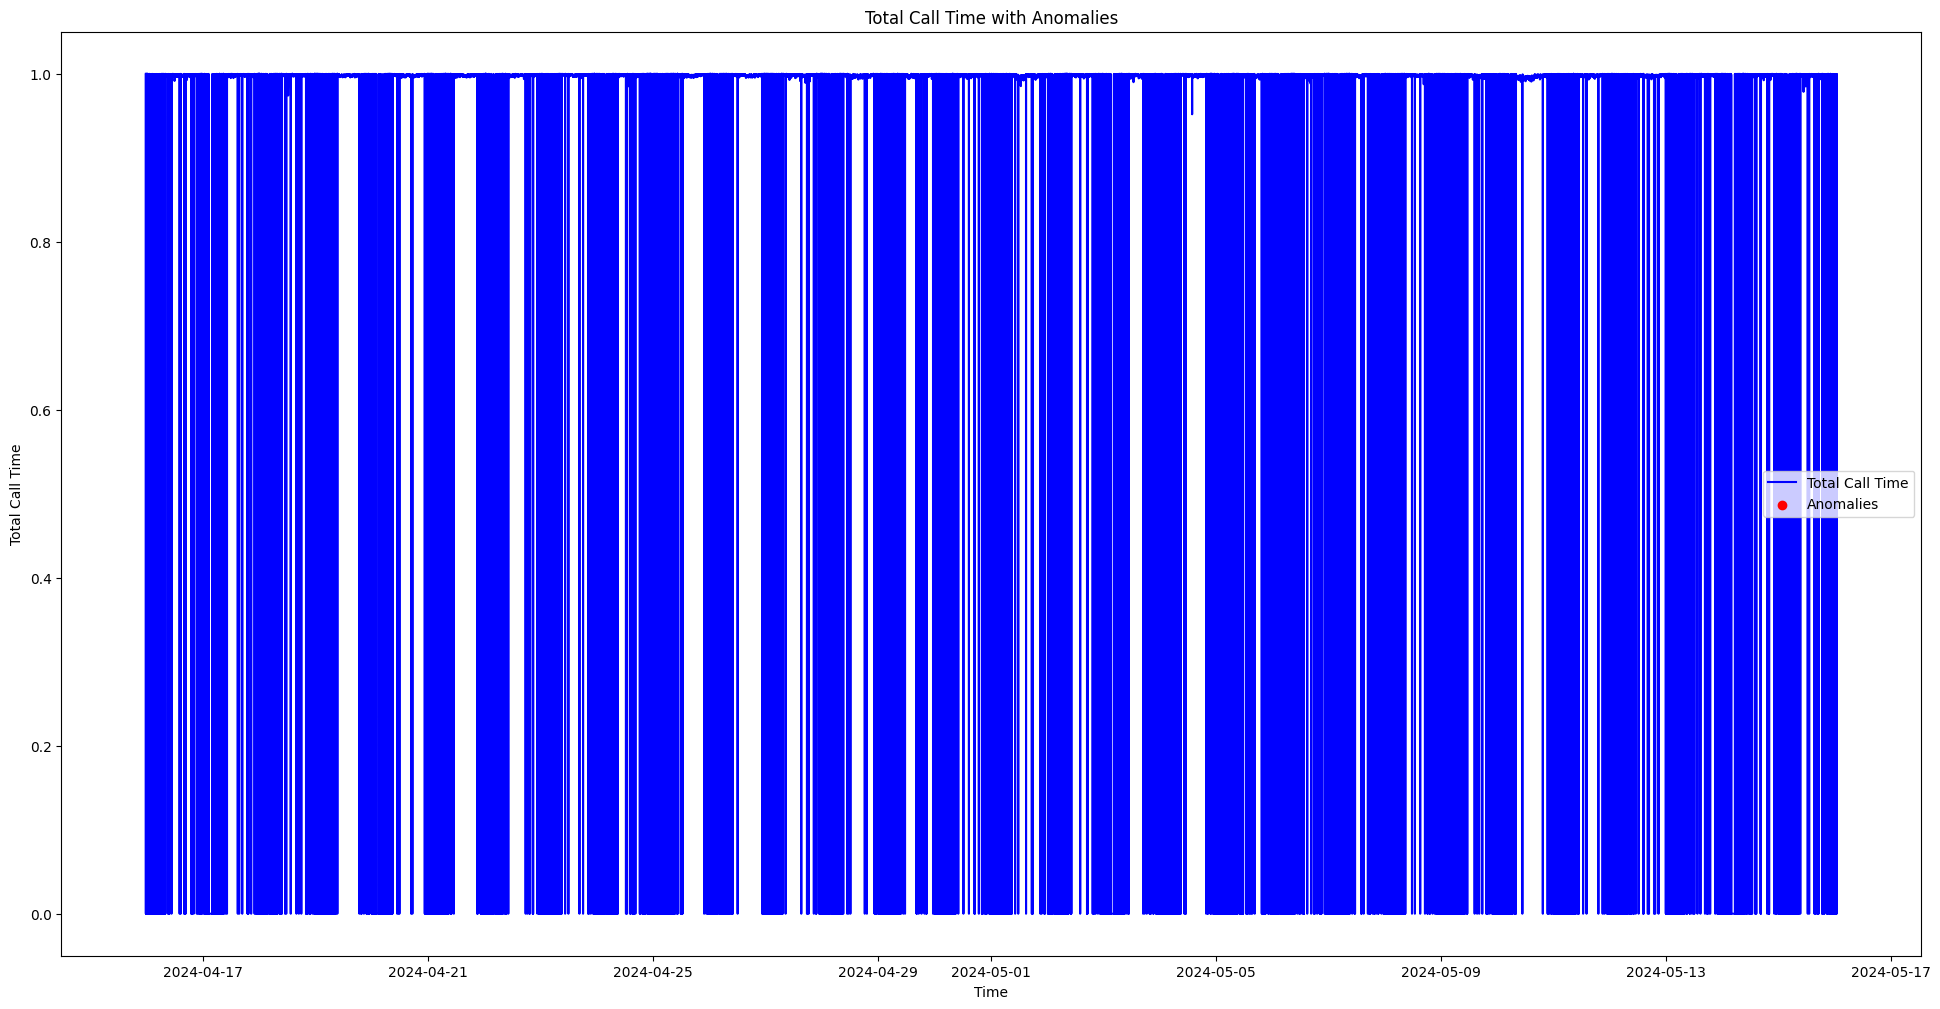

[[1713223920, 1713223980, 1713224040, 1713224100, 1713224160, 1713224220, 1713224280, 1713224340, 1713224400, 1713224460, 1713224520, 1713224580, 1713224640, 1713224700, 1713224760, 1713224820, 1713224880, 1713224940, 1713225000, 1713225060, 1713225120, 1713225180, 1713225240, 1713225300, 1713225360, 1713225420, 1713225480, 1713225540, 1713225600, 1713225660, 1713225720, 1713225780, 1713225840, 1713225900, 1713225960, 1713226020, 1713226080, 1713226140, 1713226200, 1713226260, 1713226320, 1713226380, 1713226440, 1713226500, 1713226560, 1713226620, 1713226680, 1713226740, 1713226800, 1713226860, 1713226920, 1713226980, 1713227040, 1713227100, 1713227160, 1713227220, 1713227280, 1713227340, 1713227400, 1713227460, 1713227520, 1713227580, 1713227640, 1713227700, 1713227760, 1713227820, 1713227880, 1713227940, 1713228000, 1713228060, 1713228120, 1713228180, 1713228240, 1713228300, 1713228360, 1713228420, 1713228480, 1713228540, 1713228600, 1713228660, 1713228720, 1713228780, 1713228840, 17

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from itertools import product
import warnings


#df = load_data()
# Преобразование столбца 'point' в datetime
# Создание DataFrame
for chaince in web_response_list, throughput_list, apdex_list:
    sp_anomalies = []
    df = load_data()
    data = chaince
    # Исходные данные
    timestamps = [list(entry.keys())[0] for entry in data]
    values = [list(entry.values())[0] for entry in data]
    df = pd.DataFrame(values, index=pd.to_datetime(timestamps, unit='s'), columns=['value'])

    # Преобразование столбца 'point' в datetime
    #df['point'] = pd.to_datetime(df['point'])

    # Установка 'point' как индекс
    #df.set_index('point', inplace=True)

    # Выбор столбца для анализа (например, 'total_call_time')
    ts = df['value']

    # Настройка модели ARIMA (параметры p, d, q могут варьироваться)
    model = ARIMA(ts, order=best_params)
    model_fit = model.fit()

    # Прогнозирование
    forecast = model_fit.predict(start=0, end=len(ts)-1, typ='levels')

    # Вычисление остатков (разница между фактическими и прогнозируемыми значениями)
    residuals = ts - forecast

    # Определение порога для аномалий (например, 2 стандартных отклонения)
    threshold = 6 * np.std(residuals)

    # Обнаружение аномалий
    anomalies = np.abs(residuals) > threshold
    sp_anomalies.append(list(timestamps))



    # Построение графика
    plt.figure(figsize=(24, 12))
    plt.plot(ts.index, ts, label='Total Call Time', color='blue')

    # Отображение аномалий
    plt.scatter(ts.index[anomalies], ts[anomalies], color='red', label='Anomalies')

    plt.title('Total Call Time with Anomalies')
    plt.xlabel('Time')
    plt.ylabel('Total Call Time')
    plt.legend()
    plt.show()
    print(sp_anomalies)



Необходимо подобрать нужные параметры pq для модели

In [ ]:
# Параметры для подбора
p = d = q = range(0, 3)
pdq = list(product(p, d, q))

# Подбор параметров
warnings.filterwarnings("ignore")  # отключаем предупреждения
best_aic = float("inf")
best_params = None
for param in pdq:
    try:
        model = ARIMA(ts, order=param)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_params = param
    except:
        continue

print("Best AIC:", best_aic)
print("Best Parameters:", best_params)

Best AIC: 953676.2014891175
Best Parameters: (2, 1, 2)




```
# Выбран кодовый формат
```

Best AIC: 953676.2014891175
Best Parameters: (2, 1, 2)

### Используем библиотеку ADTK

In [ ]:
!pip install adtk -quiet


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: -u


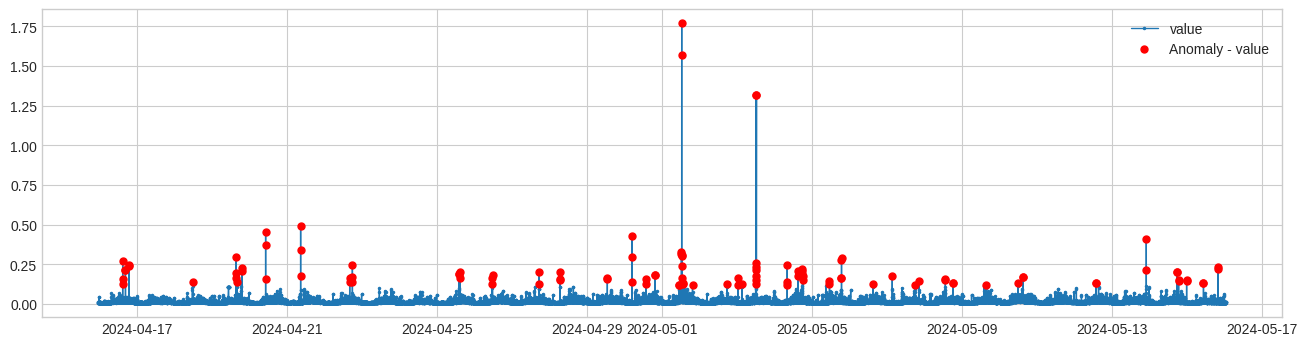

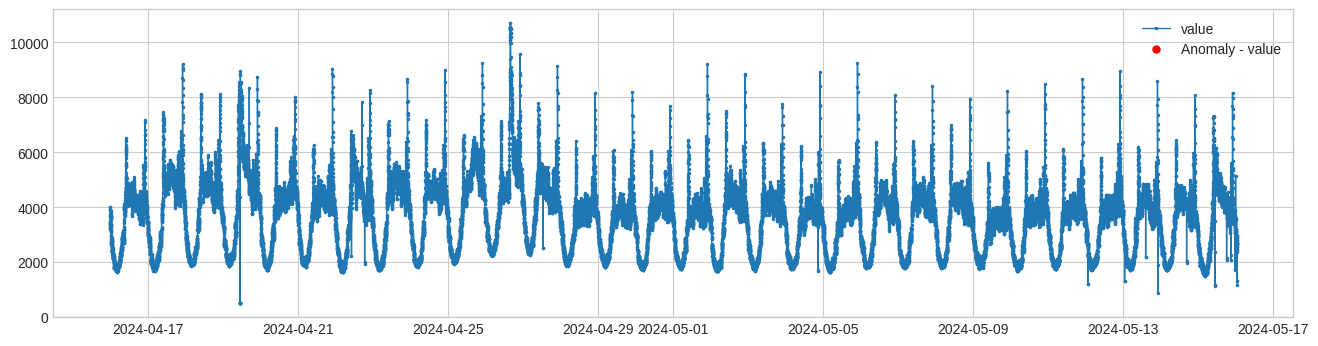

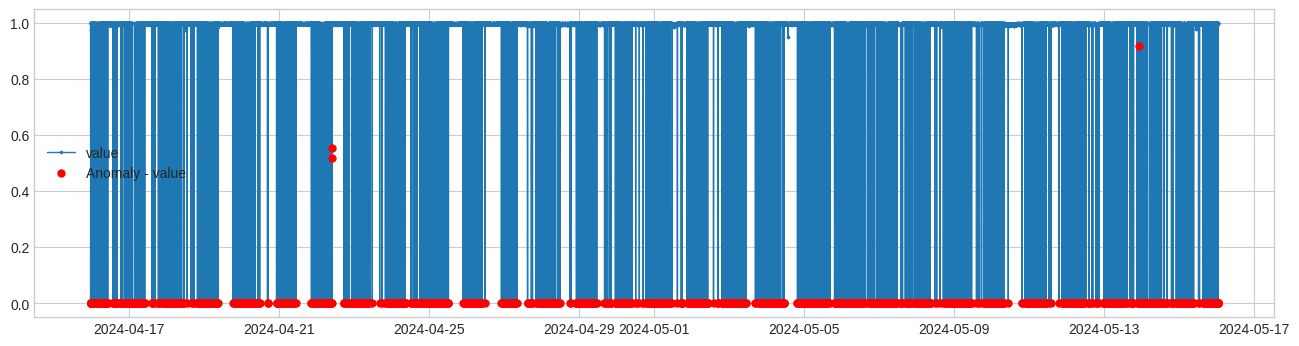

In [ ]:
from adtk.detector import InterQuartileRangeAD
from adtk.visualization import plot

for chaince in web_response_list, throughput_list, apdex_list:

  iqr_ad = InterQuartileRangeAD(c =15)
  data = chaince
  # Исходные данные
  timestamps = [list(entry.keys())[0] for entry in data]
  values = [list(entry.values())[0] for entry in data]
  df = pd.DataFrame(values, index=pd.to_datetime(timestamps, unit='s'), columns=['value'])

  # Применение детектора аномалий
  anomalies = iqr_ad.fit_detect(df)
  plot(df, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker");


Выведем список найденных аномалий

In [ ]:
from adtk.data import to_events
events = to_events(anomalies)

print(anomalies)

                     value
2024-04-15 23:32:00  False
2024-04-15 23:33:00  False
2024-04-15 23:34:00  False
2024-04-15 23:35:00  False
2024-04-15 23:36:00  False
...                    ...
2024-05-16 00:54:00  False
2024-05-16 00:55:00  False
2024-05-16 00:56:00  False
2024-05-16 00:57:00  False
2024-05-16 00:58:00  False

[43283 rows x 1 columns]


Интервалы найденных аномалий

In [ ]:
def find_anomaly_intervals(anomalies):
    anomalies = anomalies['value']
    anomaly_intervals = []
    start = None

    for i in range(len(anomalies)):
        if anomalies[i] and start is None:
            start = anomalies.index[i]
        elif not anomalies[i] and start is not None:
            end = anomalies.index[i - 1]
            anomaly_intervals.append((start, end))
            start = None

    if start is not None:
        anomaly_intervals.append((start, anomalies.index[-1]))

    return anomaly_intervals

anomaly_intervals = find_anomaly_intervals(anomalies)

In [ ]:
for interval in anomaly_intervals:
    print(interval)

(Timestamp('2024-04-16 15:06:00'), Timestamp('2024-04-16 15:07:00'))
(Timestamp('2024-04-16 16:53:00'), Timestamp('2024-04-16 16:54:00'))
(Timestamp('2024-04-16 19:01:00'), Timestamp('2024-04-16 19:02:00'))
(Timestamp('2024-04-19 15:34:00'), Timestamp('2024-04-19 15:36:00'))
(Timestamp('2024-04-19 19:33:00'), Timestamp('2024-04-19 19:34:00'))
(Timestamp('2024-04-20 10:34:00'), Timestamp('2024-04-20 10:36:00'))
(Timestamp('2024-04-21 08:58:00'), Timestamp('2024-04-21 09:00:00'))
(Timestamp('2024-04-22 16:23:00'), Timestamp('2024-04-22 16:23:00'))
(Timestamp('2024-04-22 18:07:00'), Timestamp('2024-04-22 18:08:00'))
(Timestamp('2024-04-25 14:17:00'), Timestamp('2024-04-25 14:18:00'))
(Timestamp('2024-04-25 14:57:00'), Timestamp('2024-04-25 14:58:00'))
(Timestamp('2024-04-26 11:46:00'), Timestamp('2024-04-26 11:47:00'))
(Timestamp('2024-04-27 17:25:00'), Timestamp('2024-04-27 17:25:00'))
(Timestamp('2024-04-28 06:56:00'), Timestamp('2024-04-28 06:56:00'))
(Timestamp('2024-04-28 06:58:00'),

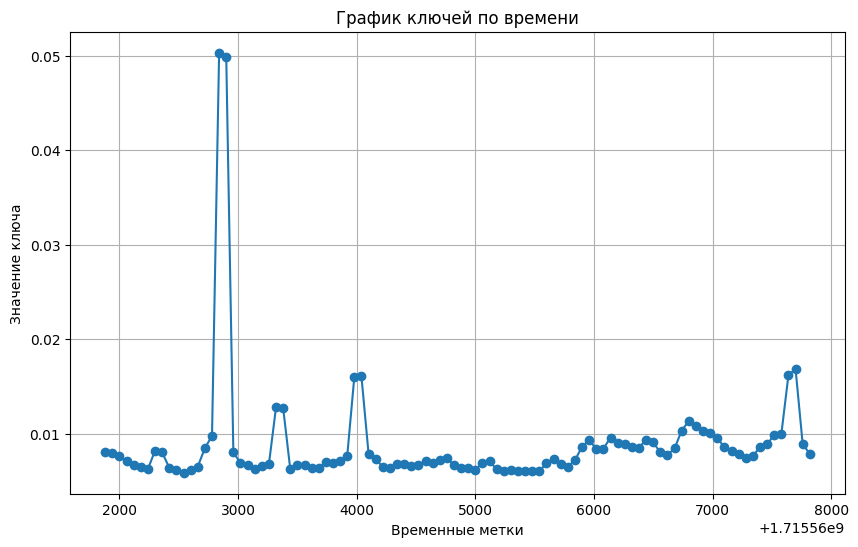

In [ ]:
import matplotlib.pyplot as plt
from datetime import datetime

data = web_response_list
# Исходные данные
timestamps = [list(entry.keys())[0] for entry in data]
values = [list(entry.values())[0] for entry in data]

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(timestamps, values, marker='o')
plt.title('График ключей по времени')
plt.xlabel('Временные метки')
plt.ylabel('Значение ключа')
plt.grid(True)
plt.show()


### Библиотека Tods

In [ ]:
!pip install tods


  Using cached tods-0.0.2.tar.gz (138 kB)
  Preparing metadata (setup.py) ... done
  Using cached d3m-2022.5.5-py3-none-any.whl (315 kB)
  Using cached numpy-1.18.2.zip (5.4 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (pyproject.toml) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import numpy as np
import pandas as pd
#from tods import generate_dataset
from tods.sk_interface.detection_algorithm.PyodKNN import *
from tods.sk_interface import fit_predict
from sklearn.metrics import classification_report

# Создание конфигурации для алгоритма
hyperparams = {
    'n_neighbors': 5,
    'method': 'largest',
    'contamination': 0.1
}


ModuleNotFoundError: No module named 'tods'

In [ ]:
# Инициализация алгоритма
df =  web_response_list
# Исходные данные
timestamps = [list(entry.keys())[0] for entry in data]
values = [list(entry.values())[0] for entry in data]

detection_algorithm = PyodKNNPrimitive(hyperparams=hyperparams)

# Применение алгоритма к данным
detection_algorithm.fit(df[['value']])
labels = detection_algorithm.predict(df[['value']])

# Добавление результатов в DataFrame
df['anomaly'] = labels


NameError: name 'web_response_list' is not defined

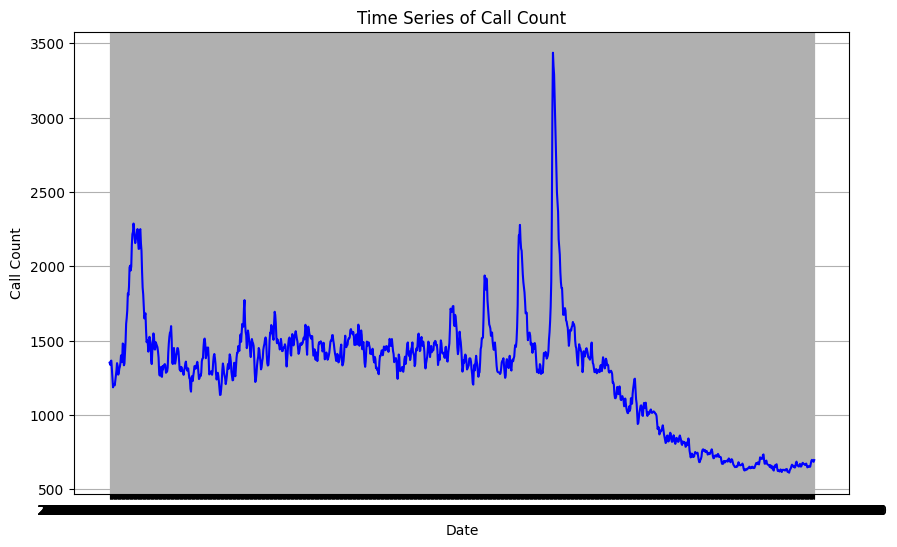

In [ ]:
# Установка столбца с датой/временем в качестве индекса
df.set_index('point', inplace=True)

# Построение графика временного ряда
plt.figure(figsize=(10, 6))
plt.plot(df['call_count'], color='blue')
plt.title('Time Series of Call Count')
plt.xlabel('Date')
plt.ylabel('Call Count')
plt.grid(True)
plt.show()

In [ ]:
data

,"<!DOCTYPE html><style nonce=""vUdyc5_T1DMRT4hMzHDnRw"">body{height:100%;margin:0;width:100%}@media (max-height:350px){.button{font-size:10px}.button-container{margin-top:16px}.button.primary-button,.button.primary-button:active,.button.primary-button:focus,.button.primary-button:hover{padding:4px 12px}.title-text{font-size:22px;line-height:24px}.subtitle-text{font-size:12px;line-height:18px}}@media (min-height:350px){.button{font-size:14px}.button-container{margin-top:16px}.button.primary-button,.button.primary-button:active,.button.primary-button:focus,.button.primary-button:hover{padding:12px 24px}.title-text{font-size:28px;line-height:36px}.subtitle-text{font-size:16px;line-height:24px}}.document-root{display:-webkit-box;display:-webkit-flex;display:-moz-box;display:-ms-flexbox;display:flex;inset:0;position:absolute}.error,.login,.request-storage-access{display:none}.error,.login,.request-storage-access,.too-many-login-redirects{margin:auto;padding:36px}.document-root.show-error .error,.document-root.show-login-page .login,.document-root.show-storage-access .request-storage-access,.too-many-login-redirects{-webkit-box-align:center;-webkit-align-items:center;-moz-box-align:center;-ms-flex-align:center;align-items:center;display:-webkit-box;display:-webkit-flex;display:-moz-box;display:-ms-flexbox;display:flex;-webkit-box-orient:vertical;-webkit-box-direction:normal;-webkit-flex-direction:column;-moz-box-orient:vertical;-moz-box-direction:normal;-ms-flex-direction:column;flex-direction:column}.button-container{display:-webkit-box;display:-webkit-flex;display:-moz-box;display:-ms-flexbox;display:flex;-webkit-flex-wrap:wrap;-ms-flex-wrap:wrap;flex-wrap:wrap;-webkit-box-pack:center;-webkit-justify-content:center;-moz-box-pack:center;-ms-flex-pack:center;justify-content:center}.button{border:none;cursor:pointer;color:#0b57d0;-webkit-flex-shrink:0;-ms-flex-negative:0;flex-shrink:0;font-family:Google Sans Text,Roboto,sans-serif;border-radius:100px;padding:12px;margin:0 8px;text-decoration:none}.button:hover{background-color:rgba(11,87,208,.078)}.button:active,.button:focus{background-color:rgba(11,87,208,.122)}.button.primary-button,.button.primary-button:active,.button.primary-button:focus,.button.primary-button:hover{background-color:#0b57d0;color:#fff}.button.primary-button:hover{box-shadow:0 1px 3px 1px rgba(0,0,0,.149),0 1px 2px 0 rgba(0,0,0,.302)}.icon{height:48px;margin-bottom:16px}.title-text{font-family:Google Sans,Roboto,sans-serif;text-align:center}.subtitle-text{font-family:Google Sans Text,Roboto,sans-serif;margin-top:16px;text-align:center}"
0,/*# sourceMappingURL=style.css.map */</style><...
1,Copyright The Closure Library Authors.
2,SPDX-License-Identifier: Apache-2.0
3,*/
4,/*
5,SPDX-License-Identifier: Apache-2.0
6,*/
7,"function n(){var a=new p,b=new q,c=document.ge..."
8,"function v(){var a=new n;w()?x()||""function""!=..."
9,"function A(a,b,c){c=c?m(b,c):b;if(a.g.get()){i..."


In [ ]:
# Преобразование колонки 'date' в тип datetime
data['date'] = pd.to_datetime(data['date'])

# Установка колонки 'date' в качестве индекса
data.set_index('date', inplace=True)

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['value'], marker='o', linestyle='-')
plt.title('Time Series Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.show()